# Visual Attention per Area Of Interest

In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import modules.GenSnippetsLib as snippets
from pygments.lexers import PythonLexer
from tqdm.notebook import tqdm
import PIL
import PIL.Image
import numpy as np
from skimage.draw import ellipse
plt.rcParams['savefig.facecolor']='white'

## Load The Data

In [2]:
def click_data_to_list(click_data_string):
    click_data_list = []
    for click in click_data_string.split(" "):
        click = click.split("-")
        # extract the x and y coordinates from a string via regex
        x = int(re.search(r'\d+', click[0])[0])
        y = int(re.search(r'\d+', click[1])[0])
        click_data_list.append((x, y))
    return click_data_list#

def time_data_to_list(time_data_string):
    time_data_list = []
    for time in time_data_string.split(" "):
        time_data_list.append(float(time) / 1000)
    return time_data_list

In [3]:
df = pd.read_csv('./data/preprocessed_experiment_data.csv')
df = df[df["Outlier"] == False]
df = df.drop(columns=["Outlier"])

df["ClickData"] = df["ClickData"].apply(lambda x: click_data_to_list(x))
df["TimeData"] = df["TimeData"].apply(lambda x: time_data_to_list(x))
df["NumberOfClicks"] = df["ClickData"].apply(lambda x: len(x))
df["AverageTimeOfClicks"] = (df["ResponseTime"] / 1000) / df["NumberOfClicks"]

## Create the Bounding Boxes of the Areas of Interest

In [4]:
# prepare color mapping for aois
algorithms = df[["Algorithm"]].sort_values(by="Algorithm")["Algorithm"].unique()
programming_styles = df[["ProgrammingStyle"]].sort_values(by="ProgrammingStyle")["ProgrammingStyle"].unique()
algorithms = [x for x in algorithms]
programming_styles = [x.replace("-", "_") for x in programming_styles]

color_palette = sns.color_palette("hls", 16)
color_palette_mapping = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "Iteration" : color_palette[6],
    "IterationHead" : color_palette[7],
    "IterationBody" : color_palette[8],
    "RecursiveCall" : color_palette[9],
    "RecursiveBaseCase" : color_palette[10],
    "HigherOrder" : color_palette[11],
    "ListComprehension" : color_palette[12],
    "InputPreparation" : color_palette[13],
    "StartOfAlgorithm" : color_palette[14],
    "Class" : color_palette[15],
}
aoi_colors = color_palette
aoi_numbers = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping.items())}
aoi_names = [name for name, _value in color_palette_mapping.items()]

def aoi_idx_to_convoluted_idx(aoi_idx):
    if aoi_idx < 5:
        return aoi_idx
    if 6 <= aoi_idx <= 12:
        return 6
    if 13 <= aoi_idx:
        return aoi_idx-6

def aoi_name_to_convoluted_name(aoi_name):
    if aoi_name in ["Iteration", "IterationHead", "IterationBody",
                    "Recursion", "RecursiveCall", "RecursiveBaseCase",
                    "HigherOrder",
                    "ListComprehension"]:
        return "StyleSpecific"
    return aoi_name

color_palette = sns.color_palette("hls", 10)
color_palette_mapping_convoluted = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "StyleSpecific" : color_palette[6],
    "InputPreparation" : color_palette[7],
    "StartOfAlgorithm" : color_palette[8],
    "Class" : color_palette[9],
}
aoi_colors_convoluted = color_palette
aoi_numbers_convoluted = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping_convoluted.items())}
aoi_names_convoluted = [name for name, _value in color_palette_mapping_convoluted.items()]

In [5]:
# create bounding boxes and visualize them
def from_canvas(fig):
    lst = list(fig.canvas.get_width_height())
    lst.append(3)
    return PIL.Image.fromarray(np.frombuffer(fig.canvas.tostring_rgb(),dtype=np.uint8).reshape(lst))

df_bounding_box = pd.DataFrame(columns=["Algorithm", "ProgrammingStyle", "BoundingBoxes", "ImageDimension"])
font_path="\\data\\fonts\\ttf\\"
offset = 3


for algorithm in tqdm(algorithms):
    for programming_style in programming_styles:
        # load the image and generate bb code info
        file_name = './data/CodeSnippets/Generators/' + algorithm + '_' + programming_style + '.json'
        try:
            image, result = snippets.create_image(file_name, font_path=font_path, lexer=PythonLexer)
            y, x = image.size[::-1]
            dimension = (x, y)
        except Exception as e:
            print(file_name + ":" + str(e))
            continue
        # extract the areas of interest in the image
        areas_of_interest = set()
        for letter in result:
            for aoi in letter["AOI"]:
                areas_of_interest.add(aoi)

        # create the bounding boxes
        disjoint_areas_of_interest = []
        for aoi in areas_of_interest:
            upper_left_x = 0
            upper_left_y = 0
            lower_right_x = 0
            lower_right_y = 0
            has_aoi = False
            for letter in result:
                if letter["BoundingBox"][0] == 0 and letter["BoundingBox"][1] == 0 and letter["BoundingBox"][2] == 0 and letter["BoundingBox"][3] == 0:
                    continue

                if aoi in letter["AOI"]:
                    if not has_aoi:
                        upper_left_x = letter["BoundingBox"][0] - offset
                        upper_left_y = letter["BoundingBox"][1] - offset
                        lower_right_x = letter["BoundingBox"][2] + offset
                        lower_right_y = letter["BoundingBox"][3] + offset
                        has_aoi = True
                    else:
                        upper_left_x = min(upper_left_x, letter["BoundingBox"][0] - offset)
                        upper_left_y = min(upper_left_y, letter["BoundingBox"][1] - offset)
                        lower_right_x = max(lower_right_x, letter["BoundingBox"][2] + offset)
                        lower_right_y = max(lower_right_y, letter["BoundingBox"][3] + offset)
                else:
                    if has_aoi:
                        disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))
                    has_aoi = False
                    upper_left_x = 0
                    upper_left_y = 0
                    lower_right_x = 0
                    lower_right_y = 0

            if has_aoi:
                disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))

        # create the bounding boxes without None aoi
        disjoint_areas_of_interest = [area for area in disjoint_areas_of_interest if area[0] != "None"]
        df_bounding_box = df_bounding_box.append(pd.DataFrame([[algorithm, programming_style.replace("_", "-"), disjoint_areas_of_interest, dimension]], columns=df_bounding_box.columns))
df_bounding_box

  0%|          | 0/11 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,BoundingBoxes,ImageDimension
0,LinkedList,higher-order,"[(HigherOrder, [162, 681, 593, 702]), (HigherO...","(594, 1206)"
0,LinkedList,iterative,"[(InputPreparation, [2, 733, 152, 1063]), (Met...","(362, 1154)"
0,LinkedList,list-comprehension,"[(InputPreparation, [2, 837, 152, 1167]), (Lis...","(706, 1232)"
0,LinkedList,recursive,"[(RecursiveCall, [258, 343, 504, 364]), (Recur...","(506, 868)"
0,apply,higher-order,"[(HigherOrder, [130, 31, 304, 52]), (InputPrep...","(394, 166)"
0,apply,iterative,"[(InputPreparation, [2, 187, 392, 208]), (Meth...","(394, 244)"
0,apply,list-comprehension,"[(InputPreparation, [2, 109, 392, 130]), (List...","(394, 166)"
0,apply,recursive,"[(RecursiveCall, [314, 109, 560, 130]), (Input...","(562, 244)"
0,computer,higher-order,"[(HigherOrder, [130, 395, 872, 416]), (InputPr...","(882, 738)"
0,computer,iterative,"[(InputPreparation, [2, 577, 576, 780]), (Meth...","(738, 842)"


## Map the Visual Attention Measures to the Areas of Interest

In [6]:
def get_ellipse_mask(center, x_radius, y_radius, dimension, std_value = 1.0):
    """
    Returns a mask of an ellipse with the given center, x-radius, and y-radius.
    """
    x_dim = max(center[0]+2*x_radius+1, dimension[0])
    y_dim = max(center[1]+2*y_radius+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    rr, cc = ellipse(center[1], center[0], y_radius, x_radius)
    mask[rr, cc] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

def get_rectangular_mask(points, dimension, std_value = 1.0):
    """
    Returns a mask of a rectangular with the given points.
    """
    x_dim = max(points[2]+1, dimension[0])
    y_dim = max(points[3]+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    mask[points[1]:points[3]+1, points[0]:points[2]+1] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

In [7]:
settings = json.load(open("./data/settings.json"))
x_radius = settings["radius_x"]+settings["grad_radius"]//2
y_radius = settings["radius_y"]+settings["grad_radius"]//2

df = pd.merge(df, df_bounding_box, on=["Algorithm", "ProgrammingStyle"])

In [8]:
df_aoi = pd.DataFrame([], columns=["Algorithm", "ProgrammingStyle", "Participant", "Number", "Duration", "AOI"])
iteration_categroies = ["Iteration", "IterationHead", "IterationBody"]
recursive_categroies = ["RecursiveCall", "RecursiveBaseCase"]
list_comprehension_categroies = ["ListComprehension"]
higher_order_categroies = ["HigherOrder"]

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    algorithm = row["Algorithm"]
    programming_style = row["ProgrammingStyle"]
    dimension = row["ImageDimension"]
    clicks = row["ClickData"]
    participant = row["ID"]

    duration_per_click = row["TimeData"]
    duration_tmp = [duration_per_click[0]]
    for duration_idx, value in enumerate(duration_per_click):
        if duration_idx == 0:
            continue
        duration_tmp.append(value-duration_per_click[duration_idx-1])
    duration_per_click = duration_tmp

    bounding_boxes = row["BoundingBoxes"]
    mask_bounding_boxes = [get_rectangular_mask(bounding_box, dimension) for _, bounding_box in bounding_boxes]
    names_of_bounding_boxes = [aoi_name for aoi_name, _ in bounding_boxes]

    for idx, (click, duration) in enumerate(zip(clicks, duration_per_click)):
        # get elliptical mask
        click_mask = get_ellipse_mask(click, x_radius, y_radius, dimension)
        aois_visited = set()
        # check if the click is in the bounding box of an aoi
        for bounding_box_name, bounding_box_mask in zip(names_of_bounding_boxes, mask_bounding_boxes):
            if np.sum(click_mask*bounding_box_mask) > 0:
                aois_visited.add(bounding_box_name)
        aois_visited_tmp = set()
        for aoi_name in aois_visited:
            if aoi_name in iteration_categroies:
                aois_visited_tmp.add("Iteration")
            elif aoi_name in recursive_categroies:
                aois_visited_tmp.add("Recursion")
            elif aoi_name in list_comprehension_categroies:
                aois_visited_tmp.add("ListComprehension")
            elif aoi_name in higher_order_categroies:
                aois_visited_tmp.add("HigherOrder")
            else:
                aois_visited_tmp.add(aoi_name)
        aois_visited = aois_visited_tmp

        df_aoi.loc[len(df_aoi)] = [algorithm, programming_style, participant, idx, duration, aois_visited]

df_aoi.reset_index(drop=True)
df_aoi

  0%|          | 0/278 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,Participant,Number,Duration,AOI
0,apply,iterative,212,0,10.105,"{InputPreparation, StartOfAlgorithm}"
1,apply,iterative,212,1,24.330,"{MethodBody, Method, Iteration}"
2,apply,iterative,212,2,0.570,"{MethodBody, Method, Iteration}"
3,apply,iterative,212,3,4.187,"{MethodBody, Method, Iteration}"
4,apply,iterative,212,4,7.954,"{Method, MethodDeclaration}"
...,...,...,...,...,...,...
6597,LinkedList,list-comprehension,315,20,3.786,{InputPreparation}
6598,LinkedList,list-comprehension,315,21,0.533,{InputPreparation}
6599,LinkedList,list-comprehension,315,22,0.468,{InputPreparation}
6600,LinkedList,list-comprehension,315,23,0.484,{InputPreparation}


## Confounding factors

In [9]:
df_confounding = pd.DataFrame([], columns=["Algorithm", "ProgrammingStyle", "AOI", "Factor"])

df_tmp = df[["Algorithm", "ProgrammingStyle", "BoundingBoxes", "ImageDimension"]]
df_tmp = df_tmp.drop_duplicates(subset=["Algorithm", "ProgrammingStyle"])
for idx, row in tqdm(df_tmp.iterrows(), total=len(df_tmp)):
    algorithm = row["Algorithm"]
    programming_style = row["ProgrammingStyle"]
    bounding_boxes = row["BoundingBoxes"]
    image_dimension = row["ImageDimension"]
    total = image_dimension[0]*image_dimension[1]

    boxes_of_aoi = [[] for _ in range(len(aoi_numbers_convoluted))]

    #aoi_name_to_convoluted_name
    for bounding_box in bounding_boxes:
        aoi_name = bounding_box[0]
        bounding_box = bounding_box[1]
        aoi_name_convoluted = aoi_name_to_convoluted_name(aoi_name)
        aoi_number_convoluted = aoi_numbers_convoluted[aoi_name_convoluted]
        boxes_of_aoi[aoi_number_convoluted].append(bounding_box)

    size_of_aoi = [0 for _ in range(len(aoi_numbers_convoluted))]
    for idx, boxes in enumerate(boxes_of_aoi):
        mask = np.zeros((image_dimension[1], image_dimension[0]))
        for box in boxes:
            mask += get_rectangular_mask(box, image_dimension)
        # count values which are not zero
        amount = len(mask[mask > 0])
        factor = amount/total
        size_of_aoi[idx] = factor

    for idx, size in enumerate(size_of_aoi):
        df_confounding.loc[len(df_confounding)] = [algorithm, programming_style, aoi_names_convoluted[idx], size]
df_confounding

  0%|          | 0/44 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,AOI,Factor
0,apply,iterative,Method,0.356963
1,apply,iterative,MethodDeclaration,0.058355
2,apply,iterative,MethodBody,0.281507
3,apply,iterative,Helper,0.000000
4,apply,iterative,HelperDeclaration,0.000000
...,...,...,...,...
435,LinkedList,list-comprehension,HelperBody,0.000000
436,LinkedList,list-comprehension,StyleSpecific,0.022234
437,LinkedList,list-comprehension,InputPreparation,0.057463
438,LinkedList,list-comprehension,StartOfAlgorithm,0.004629


## Metrics

### Raw Metrics

In [10]:
df_metrics = pd.DataFrame([], columns=["Algorithm", "ProgrammingStyle", "Participant", "AOI", "Duration", "Amount"])
for group, df_group in df_aoi.groupby(["Algorithm", "ProgrammingStyle", "Participant"]):
    algorithm = group[0]
    programming_style = group[1]
    participant = group[2]

    aoi_duration = {aoi_name : 0.0 for aoi_name in aoi_names_convoluted}
    aoi_amount = {aoi_name : 0 for aoi_name in aoi_names_convoluted}
    for idx, row in df_group.iterrows():
        duration = row["Duration"]
        aois_visited = row["AOI"]
        for aoi_name in aois_visited:
            aoi_name = aoi_name_to_convoluted_name(aoi_name)
            try:
                aoi_duration[aoi_name] += duration
                aoi_amount[aoi_name] += 1
            except:
                print(algorithm, programming_style, participant, aoi_name)
                assert False

    for aoi_name in aoi_names_convoluted:
        df_metrics.loc[len(df_metrics)] = [algorithm, programming_style, participant, aoi_name, aoi_duration[aoi_name], aoi_amount[aoi_name]]
df_metrics

,Algorithm,ProgrammingStyle,Participant,AOI,Duration,Amount
0,LinkedList,higher-order,204,Method,25.186,8
1,LinkedList,higher-order,204,MethodDeclaration,12.515,3
2,LinkedList,higher-order,204,MethodBody,21.321,7
3,LinkedList,higher-order,204,Helper,0.000,0
4,LinkedList,higher-order,204,HelperDeclaration,0.000,0
...,...,...,...,...,...,...
2775,store,recursive,320,HelperBody,29.130,19
2776,store,recursive,320,StyleSpecific,39.201,25
2777,store,recursive,320,InputPreparation,27.612,20
2778,store,recursive,320,StartOfAlgorithm,0.832,1


In [11]:
aoi_order = ['Class',
             'Method','MethodDeclaration','MethodBody',
             'Helper','HelperDeclaration','HelperBody',
             'InputPreparation', 'StartOfAlgorithm',
             'StyleSpecific']

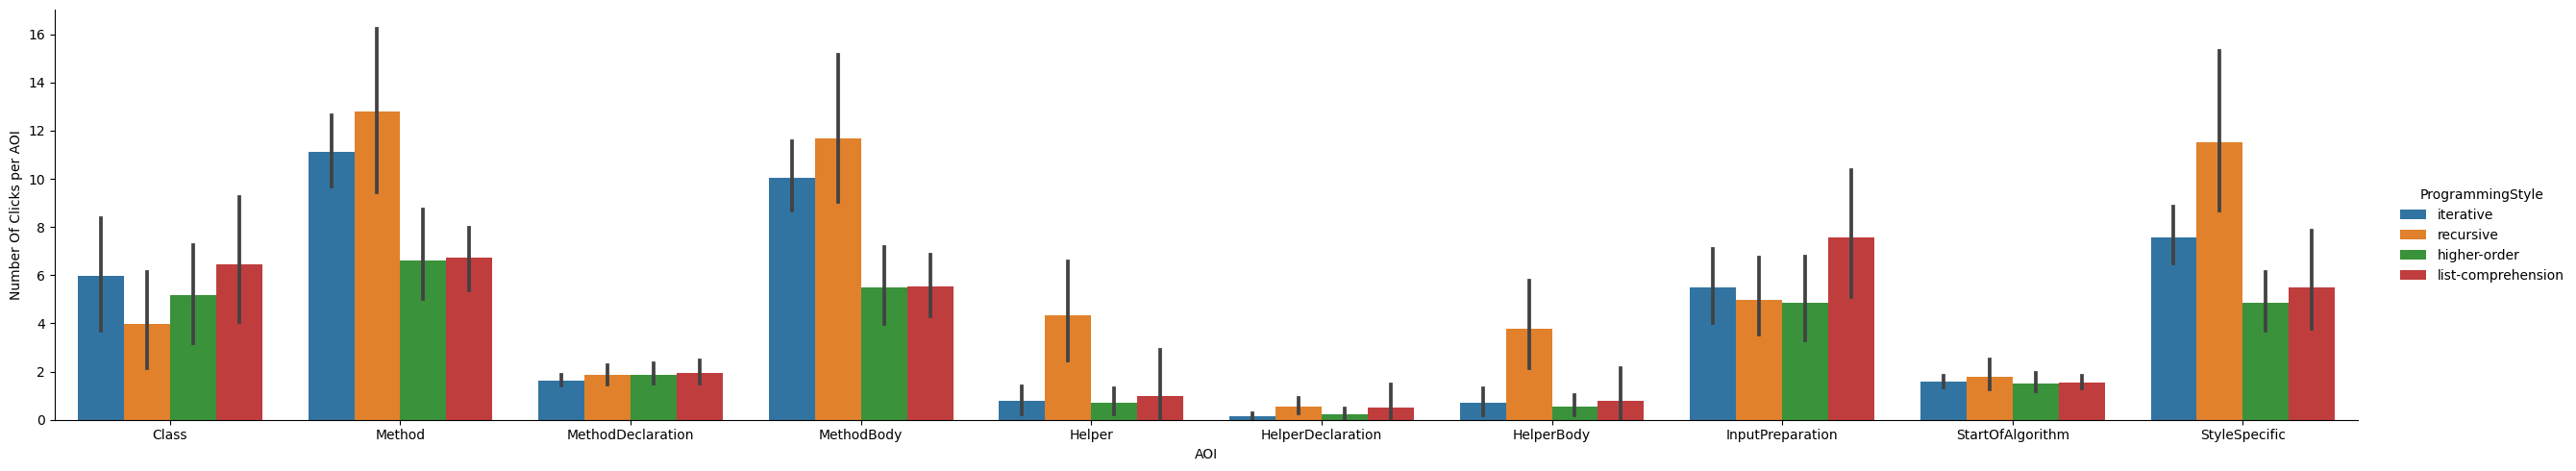

In [12]:
df_tmp = df_metrics.copy()

ax = sns.catplot(x="AOI", y="Amount", hue="ProgrammingStyle", data=df_tmp, kind="bar", height=5,
                 aspect=5, hue_order=["iterative", "recursive", "higher-order", "list-comprehension"],
                 order=aoi_order)
ax.tight_layout()
ax.set(ylabel='Number Of Clicks per AOI')
plt.savefig("./results/visual_attention_number_of_clicks_per_aoi.png")
plt.show()
plt.close('all')

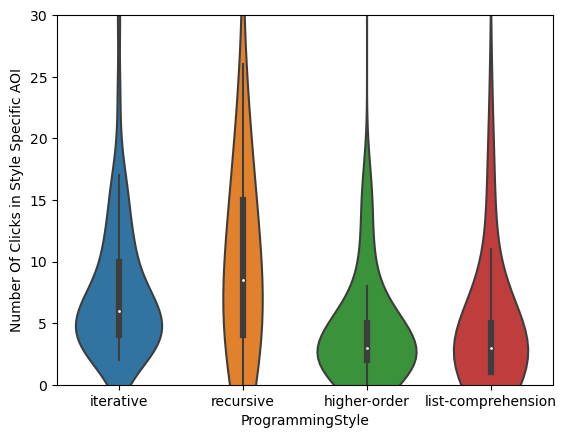

In [13]:
df_total = df_metrics.copy()
df_total["Amount"] = df_total["Amount"].astype(float)
df_total = df_total[df_total["AOI"] == "StyleSpecific"]
ax = sns.violinplot(x="ProgrammingStyle", y="Amount", data=df_total,
                    order=["iterative", "recursive", "higher-order", "list-comprehension"])
ax.set_ylabel('Number Of Clicks in Style Specific AOI')
ax.set(ylim=(0.0, 30.0))
plt.savefig("./results/visual_attention_number_of_clicks_in_style_specific.png")
plt.show()
plt.close('all')

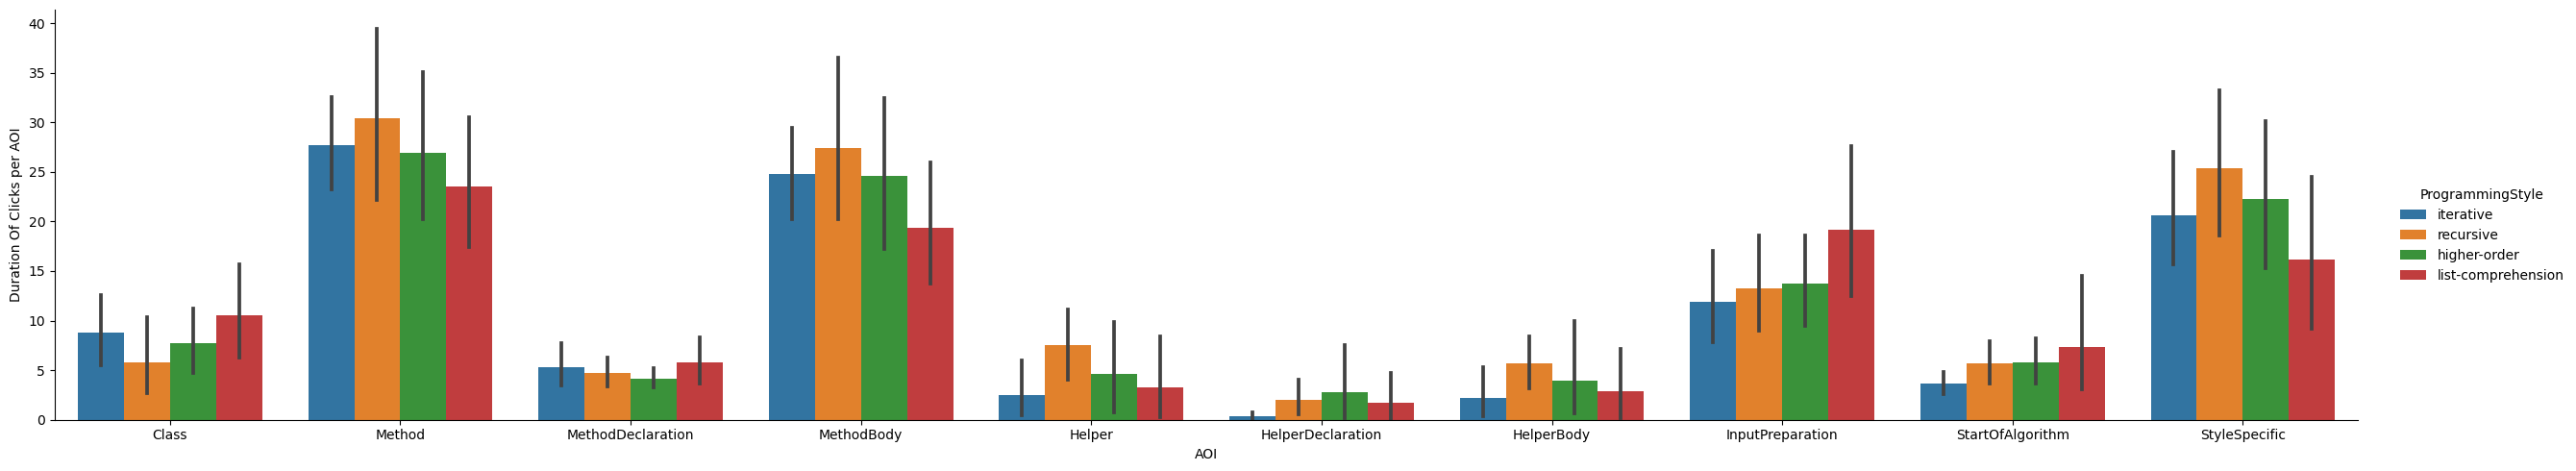

In [14]:
df_total = df_metrics

ax = sns.catplot(x="AOI", y="Duration", hue="ProgrammingStyle", data=df_tmp, kind="bar", height=5,
                 aspect=5, hue_order=["iterative", "recursive", "higher-order", "list-comprehension"],
                 order=aoi_order)
ax.tight_layout()
ax.set(ylabel='Duration Of Clicks per AOI')
plt.savefig("./results/visual_attention_duration_of_clicks_per_aoi.png")
plt.show()
plt.close('all')

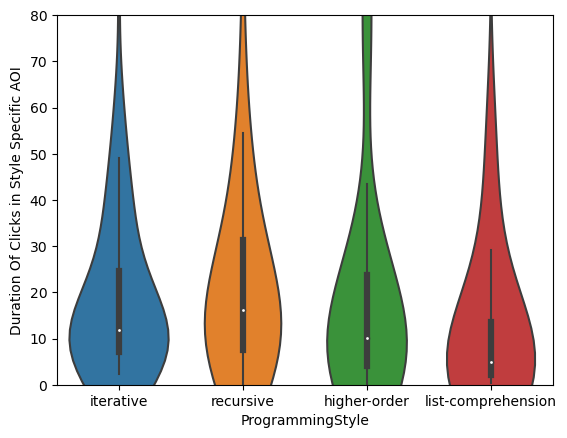

In [15]:
df_total = df_metrics
df_total = df_total[df_total["AOI"] == "StyleSpecific"]
ax = sns.violinplot(x="ProgrammingStyle", y="Duration", data=df_total,
                    order=["iterative", "recursive", "higher-order", "list-comprehension"])
plt.savefig("./results/visual_attention_duration_of_clicks_in_style_specific.png")
ax.set_ylabel('Duration Of Clicks in Style Specific AOI')
ax.set(ylim=(0.0, 80.0))
plt.show()
plt.close('all')